# Lab 1.2.3: Visualization Dashboard

**Module:** 1.2 - Python for AI/ML  
**Time:** 2 hours  
**Difficulty:** ⭐⭐

---

## 🎯 Learning Objectives

By the end of this notebook, you will:
- [ ] Create multi-panel figures using Matplotlib subplots
- [ ] Visualize training/validation loss curves
- [ ] Create confusion matrix heatmaps with Seaborn
- [ ] Build feature importance and distribution plots
- [ ] Apply consistent, publication-ready styling

---

## 📚 Prerequisites

- Completed: Labs 1.2.1 and 1.2.2
- Knowledge of: NumPy, basic Pandas

### Required Packages
- Python 3.9+
- NumPy >= 1.21
- Pandas >= 1.3
- Matplotlib >= 3.5
- Seaborn >= 0.11 (optional, but recommended)

---

## 🌍 Real-World Context

**Why are visualizations crucial for ML?**

Numbers tell part of the story. Visualizations tell the rest:

- **Training curves** reveal if your model is overfitting, underfitting, or just right
- **Confusion matrices** show exactly where your classifier is making mistakes
- **Feature importance** helps explain model decisions to stakeholders
- **Distribution plots** reveal data quality issues before they become model problems

**In industry:**
- Data scientists present visualizations to justify model choices
- Engineers use plots to debug model training issues
- Research papers require publication-quality figures

---

## 🧒 ELI5: Why Visualize?

> **Imagine you're a detective solving a mystery...** 🔍
>
> You have a notebook full of clues (numbers).
> But it's easier to see patterns when you:
> - Draw a timeline of events (line plot)
> - Make a board with photos of suspects (confusion matrix)
> - Show which clues are most important (bar chart)
>
> **In AI terms:** Our brains are visual. A good plot can reveal patterns
> that would take hours to find in raw numbers!

---

In [1]:
# ============================================================
# Environment Setup and Dependency Checks
# ============================================================
import sys
import subprocess
from pathlib import Path

# Determine the notebook's directory for reliable path resolution
try:
    notebook_dir = Path(__vsc_ipynb_file__).parent  # VS Code
except NameError:
    notebook_dir = Path.cwd()  # Fallback

# Add scripts directory to path
scripts_dir = (notebook_dir / '../scripts').resolve()
if scripts_dir.exists() and str(scripts_dir) not in sys.path:
    sys.path.insert(0, str(scripts_dir))
elif not scripts_dir.exists():
    scripts_dir = Path('../scripts').resolve()
    if scripts_dir.exists() and str(scripts_dir) not in sys.path:
        sys.path.insert(0, str(scripts_dir))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

# Try to import seaborn (optional but recommended)
try:
    import seaborn as sns
    HAS_SEABORN = True
    print(f"Seaborn version: {sns.__version__}")
except ImportError:
    HAS_SEABORN = False
    sns = None  # Define sns as None so we can check it
    print("⚠️ Seaborn not installed. Confusion matrix cells will use matplotlib fallback.")
    print("   Install with: pip install seaborn")

# Helper function for heatmaps without seaborn
# NOTE: This helper is defined inline rather than imported from visualization_utils.py
# to demonstrate how to build visualization functions from scratch as a learning exercise.
# For production code, consider using the MLVisualizer class from utils.visualization
def plot_heatmap(data, ax, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=None, yticklabels=None, cbar_kws=None):
    """
    Plot a heatmap using matplotlib (with seaborn fallback when available).
    
    This function provides a seaborn-like API but falls back to pure matplotlib
    when seaborn is not installed, ensuring the notebook works in all environments.
    
    Args:
        data: 2D array of values to plot
        ax: Matplotlib axes object
        annot: Whether to annotate cells with values
        fmt: Format string for annotations ('d' for int, '.1%' for percent)
        cmap: Colormap name
        xticklabels: Labels for x-axis
        yticklabels: Labels for y-axis
        cbar_kws: Dict of colorbar keyword arguments
    """
    if HAS_SEABORN:
        sns.heatmap(data, annot=annot, fmt=fmt, cmap=cmap,
                   xticklabels=xticklabels, yticklabels=yticklabels,
                   ax=ax, cbar_kws=cbar_kws)
    else:
        im = ax.imshow(data, cmap=cmap, aspect='auto')
        plt.colorbar(im, ax=ax, label=cbar_kws.get('label', '') if cbar_kws else '')
        
        # Add text annotations
        if annot:
            for i in range(data.shape[0]):
                for j in range(data.shape[1]):
                    value = data[i, j]
                    if fmt == 'd':
                        text = f'{int(value)}'
                    elif fmt == '.1%':
                        text = f'{value:.1%}'
                    elif fmt == '.0%':
                        text = f'{value:.0%}'
                    else:
                        text = f'{value}'
                    color = 'white' if value > data.max() / 2 else 'black'
                    ax.text(j, i, text, ha='center', va='center', color=color)
        
        if xticklabels is not None:
            ax.set_xticks(range(len(xticklabels)))
            ax.set_xticklabels(xticklabels)
        if yticklabels is not None:
            ax.set_yticks(range(len(yticklabels)))
            ax.set_yticklabels(yticklabels)

# Set default style with fallback for different matplotlib versions
style_set = False
for style_name in ['seaborn-v0_8-whitegrid', 'seaborn-whitegrid', 'ggplot']:
    try:
        plt.style.use(style_name)
        print(f"Using matplotlib style: {style_name}")
        style_set = True
        break
    except OSError:
        continue

if not style_set:
    print("Using default matplotlib style")

# Configure matplotlib defaults for publication-ready figures
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10

print(f"\nPython version: {sys.version.split()[0]}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

# Check if data files exist
data_dir = (notebook_dir / '../data').resolve()
if not data_dir.exists():
    data_dir = Path('../data').resolve()

required_files = ['sample_training_history.json', 'sample_confusion_data.json']
missing_files = [f for f in required_files if not (data_dir / f).exists()]

if missing_files:
    print(f"\n⚠️ Data files not found: {missing_files}")
    generator_script = data_dir / 'generate_sample_data.py'
    if generator_script.exists():
        print("   Generating sample data...")
        result = subprocess.run([sys.executable, str(generator_script)], 
                               capture_output=True, text=True, cwd=str(data_dir))
        if result.returncode == 0:
            print("   ✅ Sample data generated!")
        else:
            print(f"   ❌ Error: {result.stderr}")
else:
    print(f"\n✅ Data files present")

print(f"\n{'='*50}")
print("Welcome to the Visualization Dashboard Lab! 📊")
print(f"{'='*50}")

Seaborn version: 0.13.2
Using matplotlib style: seaborn-v0_8-whitegrid

Python version: 3.12.3
NumPy version: 2.1.0
Matplotlib version: 3.10.6

✅ Data files present

Welcome to the Visualization Dashboard Lab! 📊


---

## Part 1: Training and Validation Curves

The most important visualization during model training!

In [2]:
# Generate realistic training history data
np.random.seed(42)

epochs = 100
x = np.arange(1, epochs + 1)

# Simulate training loss (decreasing with noise)
train_loss = 2.5 * np.exp(-0.05 * x) + 0.15 + np.random.normal(0, 0.02, epochs)

# Simulate validation loss (decreases then increases = overfitting)
val_loss = 2.5 * np.exp(-0.04 * x) + 0.25 + np.random.normal(0, 0.03, epochs)
val_loss[50:] += 0.003 * (x[50:] - 50)  # Overfitting after epoch 50

# Simulate accuracy (inverse of loss, roughly)
train_acc = 1 - 0.4 * np.exp(-0.05 * x) + np.random.normal(0, 0.01, epochs)
train_acc = np.clip(train_acc, 0, 1)

val_acc = 1 - 0.45 * np.exp(-0.04 * x) + np.random.normal(0, 0.015, epochs)
val_acc[50:] -= 0.002 * (x[50:] - 50)
val_acc = np.clip(val_acc, 0, 1)

print("Training history generated!")
print(f"  Epochs: {epochs}")
print(f"  Final train loss: {train_loss[-1]:.4f}")
print(f"  Final val loss: {val_loss[-1]:.4f}")
print(f"  Best val loss at epoch: {np.argmin(val_loss) + 1}")

Training history generated!
  Epochs: 100
  Final train loss: 0.1622
  Final val loss: 0.4115
  Best val loss at epoch: 90


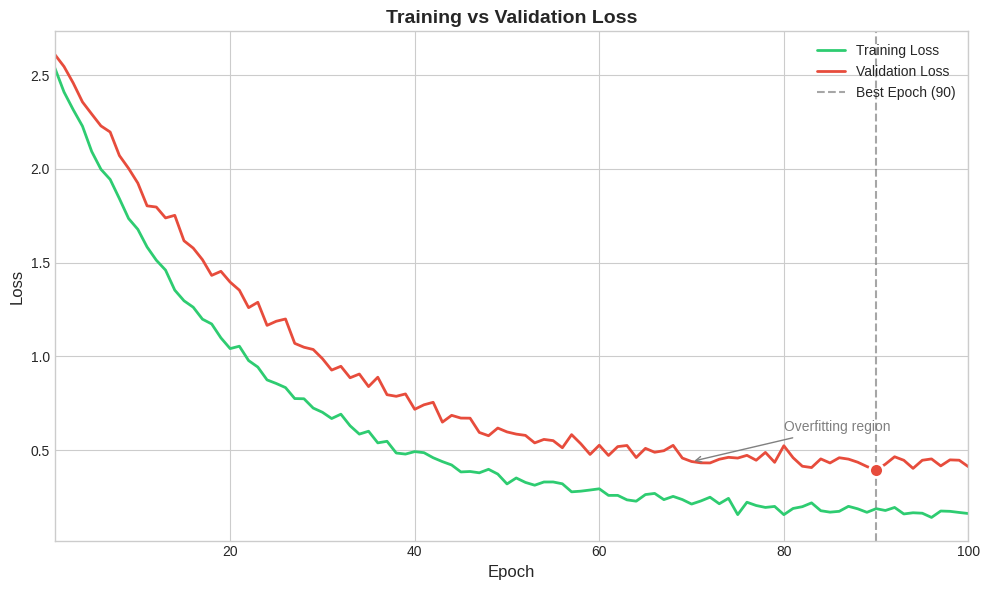


✨ The gap between training and validation loss after epoch 90 indicates overfitting!


In [3]:
# Basic training curve
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x, train_loss, label='Training Loss', color='#2ecc71', linewidth=2)
ax.plot(x, val_loss, label='Validation Loss', color='#e74c3c', linewidth=2)

# Mark the best epoch
best_epoch = np.argmin(val_loss) + 1
ax.axvline(x=best_epoch, color='gray', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
ax.scatter([best_epoch], [val_loss[best_epoch-1]], color='#e74c3c', s=100, zorder=5, edgecolors='white', linewidth=2)

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.set_xlim(1, epochs)

# Add annotation for overfitting region
ax.annotate('Overfitting region', 
            xy=(70, val_loss[69]), 
            xytext=(80, 0.6),
            arrowprops=dict(arrowstyle='->', color='gray'),
            fontsize=10, color='gray')

plt.tight_layout()
plt.show()

print(f"\n✨ The gap between training and validation loss after epoch {best_epoch} indicates overfitting!")

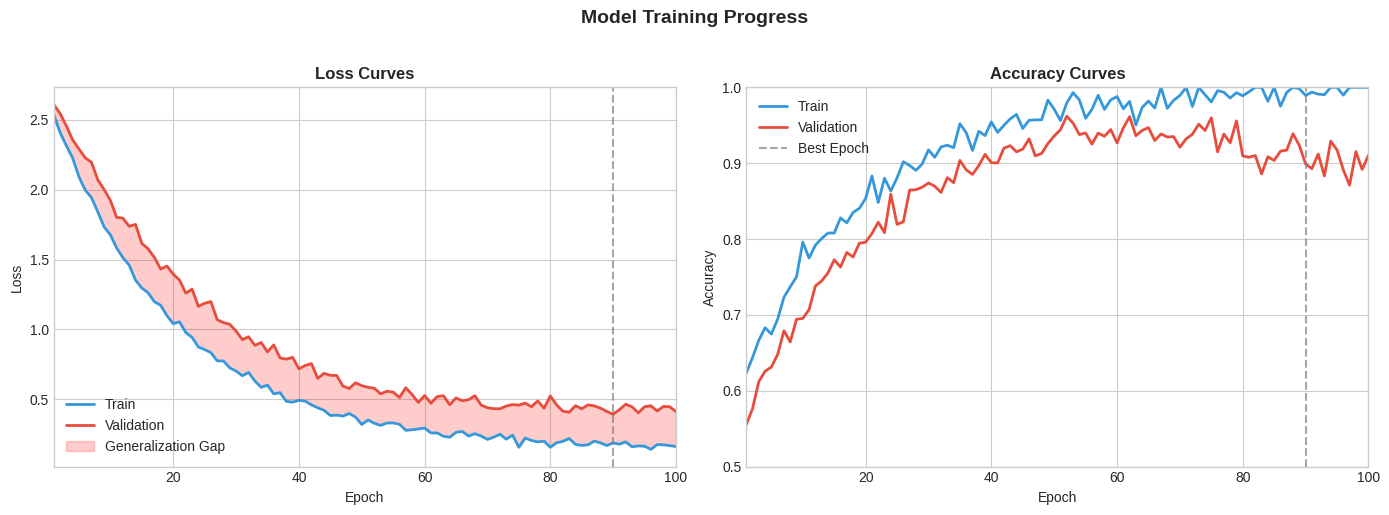

In [4]:
# Professional dual-panel plot (loss + accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss subplot
ax1.plot(x, train_loss, label='Train', color='#3498db', linewidth=2)
ax1.plot(x, val_loss, label='Validation', color='#e74c3c', linewidth=2)
ax1.fill_between(x, train_loss, val_loss, alpha=0.2, color='red', 
                  where=(val_loss > train_loss), label='Generalization Gap')
ax1.axvline(x=best_epoch, color='gray', linestyle='--', alpha=0.7)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curves', fontweight='bold')
ax1.legend()
ax1.set_xlim(1, epochs)

# Accuracy subplot
ax2.plot(x, train_acc, label='Train', color='#3498db', linewidth=2)
ax2.plot(x, val_acc, label='Validation', color='#e74c3c', linewidth=2)
ax2.axvline(x=best_epoch, color='gray', linestyle='--', alpha=0.7, label=f'Best Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves', fontweight='bold')
ax2.legend()
ax2.set_xlim(1, epochs)
ax2.set_ylim(0.5, 1.0)

plt.suptitle('Model Training Progress', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 🔍 What These Curves Tell Us

| Pattern | Meaning | Action |
|---------|---------|--------|
| Both losses decreasing together | Model is learning well | Keep training |
| Train loss ↓, Val loss ↑ | Overfitting | Early stopping, regularization |
| Both losses high | Underfitting | More epochs, bigger model |
| Large gap from start | Too complex model | Simpler architecture |

---

## Part 2: Confusion Matrix Heatmaps

Essential for understanding classification errors!

In [5]:
# Generate a sample confusion matrix
# 5-class classification (e.g., sentiment: Very Neg, Neg, Neutral, Pos, Very Pos)

np.random.seed(42)
n_classes = 5
class_names = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']

# Create a realistic confusion matrix (most predictions on diagonal)
cm = np.zeros((n_classes, n_classes), dtype=int)
n_samples_per_class = 200

for i in range(n_classes):
    # Most predictions are correct
    cm[i, i] = int(n_samples_per_class * (0.6 + 0.2 * np.random.random()))
    
    # Adjacent class confusion is common in ordinal problems
    remaining = n_samples_per_class - cm[i, i]
    for j in range(n_classes):
        if i != j:
            distance = abs(i - j)
            prob = 0.4 ** distance
            cm[i, j] = int(remaining * prob / sum(0.4 ** abs(i - k) for k in range(n_classes) if k != i))

print("Confusion Matrix (raw counts):")
print(cm)

Confusion Matrix (raw counts):
[[134  40  16   6   2]
 [ 16 158  16   6   2]
 [  7  18 149  18   7]
 [  3   8  22 143  22]
 [  2   7  18  45 126]]


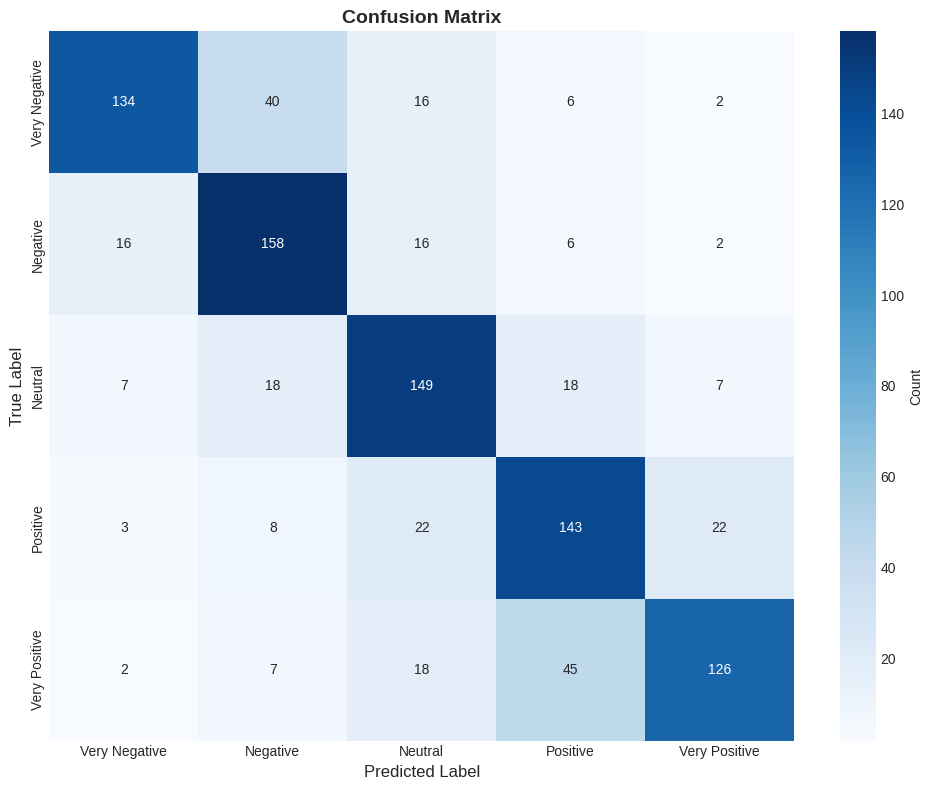

In [6]:
# Basic confusion matrix heatmap
fig, ax = plt.subplots(figsize=(10, 8))

plot_heatmap(cm, ax=ax, annot=True, fmt='d', cmap='Blues',
             xticklabels=class_names, yticklabels=class_names,
             cbar_kws={'label': 'Count'})

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

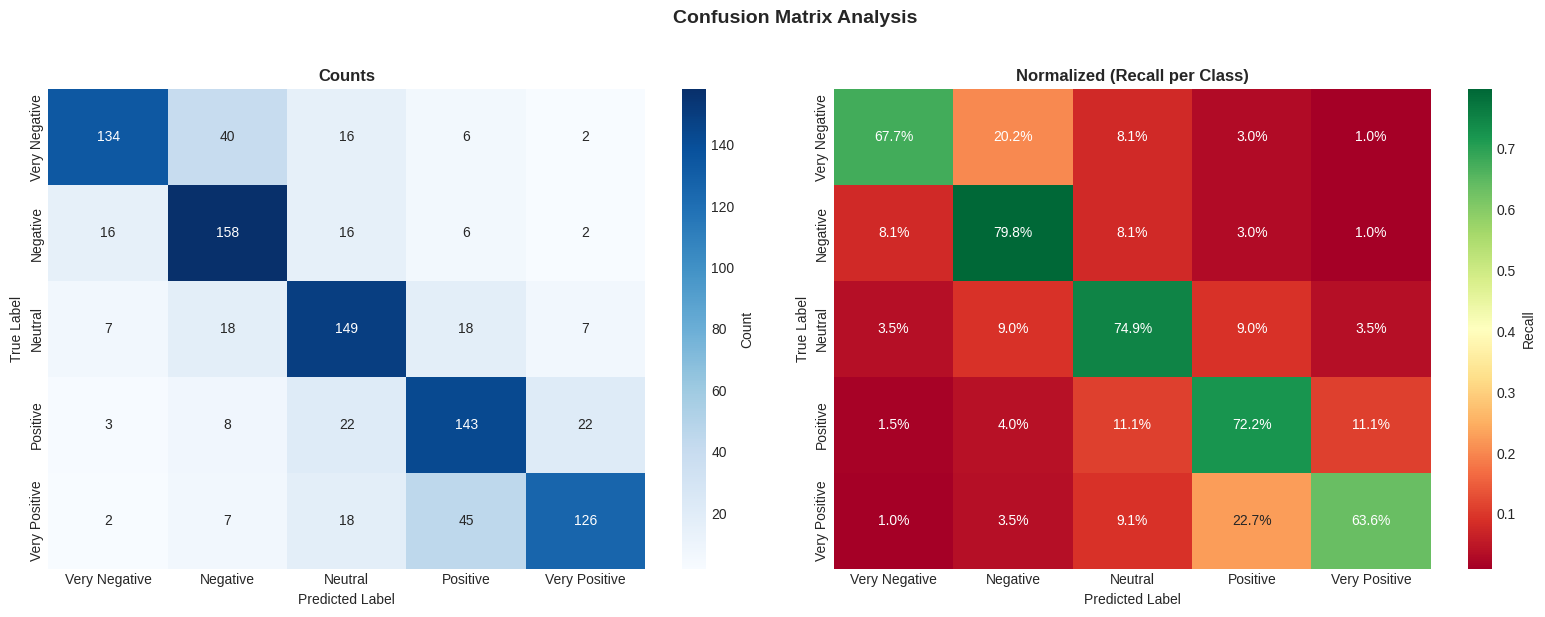


📊 Overall Accuracy: 71.6%

📊 Per-class Recall:
   Very Negative: 67.7%
   Negative: 79.8%
   Neutral: 74.9%
   Positive: 72.2%
   Very Positive: 63.6%


In [7]:
# Enhanced confusion matrix with percentages side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
plot_heatmap(cm, ax=ax1, annot=True, fmt='d', cmap='Blues',
             xticklabels=class_names, yticklabels=class_names,
             cbar_kws={'label': 'Count'})
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')
ax1.set_title('Counts', fontweight='bold')

# Normalized (percentages per true class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plot_heatmap(cm_normalized, ax=ax2, annot=True, fmt='.1%', cmap='RdYlGn',
             xticklabels=class_names, yticklabels=class_names,
             cbar_kws={'label': 'Recall'})
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')
ax2.set_title('Normalized (Recall per Class)', fontweight='bold')

plt.suptitle('Confusion Matrix Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Calculate metrics
accuracy = np.trace(cm) / cm.sum()
print(f"\n📊 Overall Accuracy: {accuracy:.1%}")
print("\n📊 Per-class Recall:")
for i, name in enumerate(class_names):
    recall = cm[i, i] / cm[i, :].sum()
    print(f"   {name}: {recall:.1%}")

---

## Part 3: Feature Importance Bar Charts

In [8]:
# Generate feature importance data (like from a Random Forest)
feature_names = [
    'income', 'credit_score', 'age', 'years_employed', 
    'education_level', 'debt_ratio', 'num_accounts',
    'recent_inquiries', 'payment_history', 'utilization'
]

np.random.seed(42)
importances = np.random.exponential(0.1, len(feature_names))
importances = importances / importances.sum()  # Normalize to sum to 1

# Sort for display
sorted_idx = np.argsort(importances)
sorted_names = [feature_names[i] for i in sorted_idx]
sorted_values = importances[sorted_idx]

print("Feature Importances:")
for name, value in zip(feature_names, importances):
    print(f"  {name}: {value:.3f}")

Feature Importances:
  income: 0.046
  credit_score: 0.293
  age: 0.128
  years_employed: 0.089
  education_level: 0.017
  debt_ratio: 0.017
  num_accounts: 0.006
  recent_inquiries: 0.196
  payment_history: 0.089
  utilization: 0.120


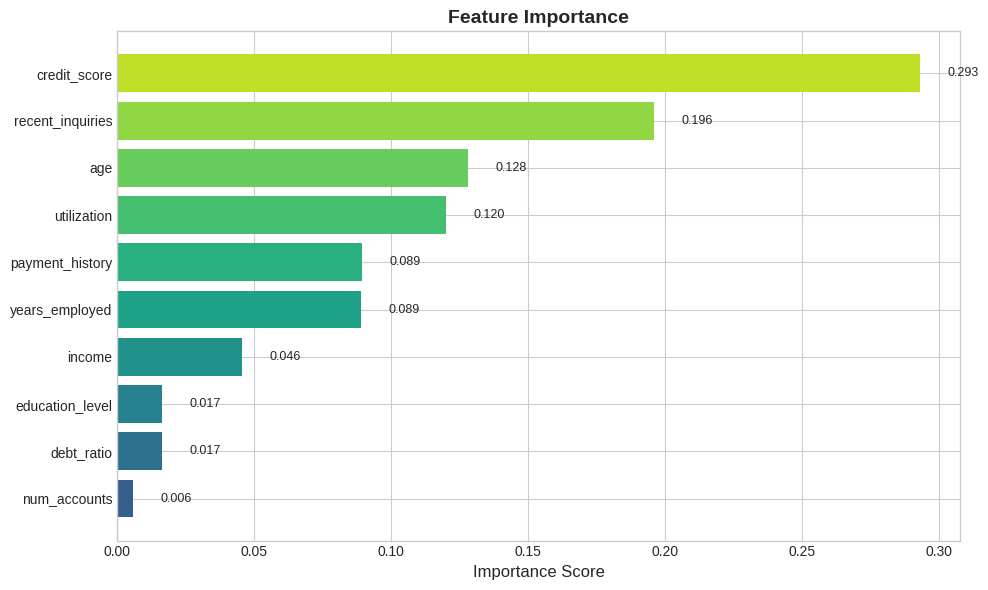

In [9]:
# Horizontal bar chart (best for many features)
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(sorted_names)))

bars = ax.barh(range(len(sorted_names)), sorted_values, color=colors)
ax.set_yticks(range(len(sorted_names)))
ax.set_yticklabels(sorted_names)
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Feature Importance', fontsize=14, fontweight='bold')

# Add value labels
for bar, value in zip(bars, sorted_values):
    ax.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{value:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

---

## Part 4: Distribution Plots and Histograms

In [10]:
# Generate prediction distributions
np.random.seed(42)

# Two-class predictions with some overlap
class_0_preds = np.random.beta(2, 5, 500)  # Tends lower
class_1_preds = np.random.beta(5, 2, 500)  # Tends higher

all_predictions = np.concatenate([class_0_preds, class_1_preds])
all_labels = np.array([0] * 500 + [1] * 500)

print(f"Class 0 predictions: mean={class_0_preds.mean():.3f}, std={class_0_preds.std():.3f}")
print(f"Class 1 predictions: mean={class_1_preds.mean():.3f}, std={class_1_preds.std():.3f}")

Class 0 predictions: mean=0.287, std=0.152
Class 1 predictions: mean=0.715, std=0.153


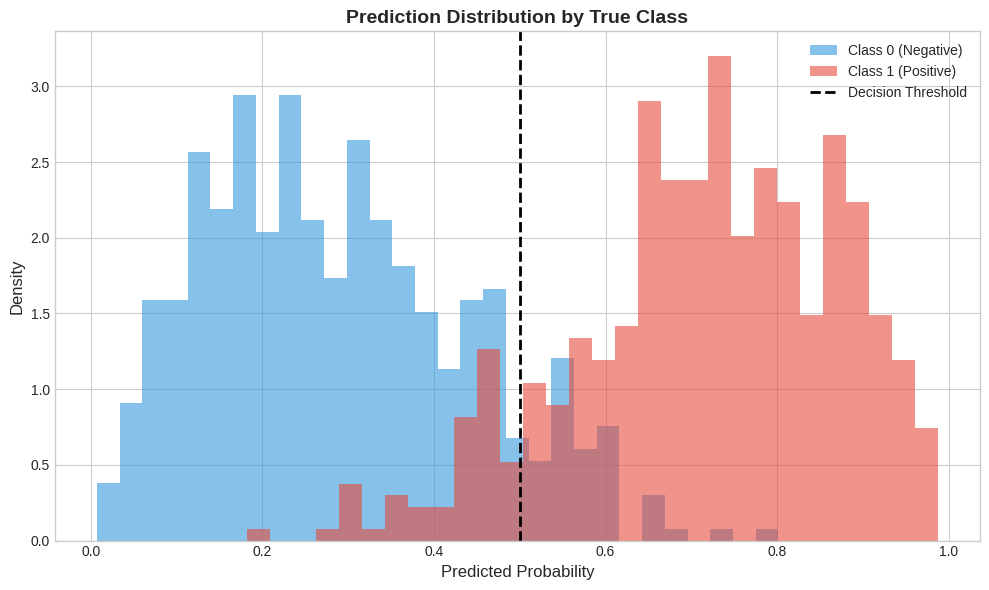


💡 Overlap in the middle indicates prediction uncertainty.
   A well-calibrated model has good separation between classes.


In [11]:
# Overlapping histograms by class
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(class_0_preds, bins=30, alpha=0.6, label='Class 0 (Negative)', color='#3498db', density=True)
ax.hist(class_1_preds, bins=30, alpha=0.6, label='Class 1 (Positive)', color='#e74c3c', density=True)

# Add threshold line
ax.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')

ax.set_xlabel('Predicted Probability', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Prediction Distribution by True Class', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

print("\n💡 Overlap in the middle indicates prediction uncertainty.")
print("   A well-calibrated model has good separation between classes.")

---

## Part 5: Building the Complete Dashboard

Now let's combine everything into a publication-ready 2x2 dashboard!

### 📚 GridSpec: Advanced Subplot Layouts

For complex multi-panel figures, we use `GridSpec` from matplotlib. It provides more control than `plt.subplots()`.

**Basic usage:**
```python
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(14, 12))
gs = GridSpec(2, 2, figure=fig)  # 2 rows, 2 columns

ax1 = fig.add_subplot(gs[0, 0])  # Top-left
ax2 = fig.add_subplot(gs[0, 1])  # Top-right
ax3 = fig.add_subplot(gs[1, 0])  # Bottom-left
ax4 = fig.add_subplot(gs[1, 1])  # Bottom-right
```

**Why GridSpec?**
- Control spacing with `hspace` (height) and `wspace` (width)
- Span multiple cells: `gs[0, :]` spans entire top row
- Mix different subplot sizes in one figure

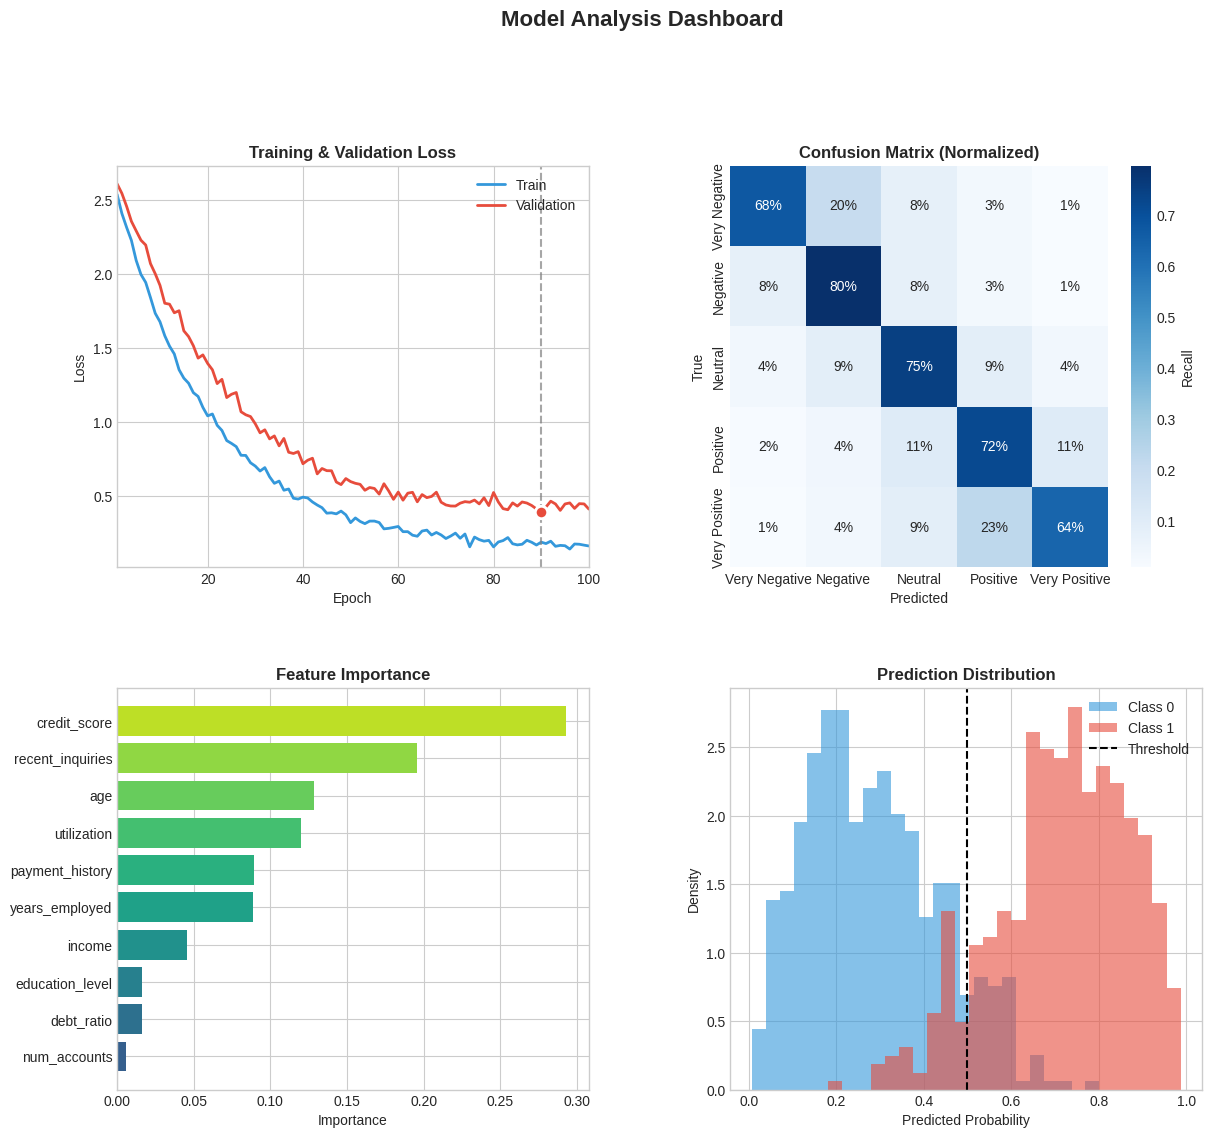


🎉 Dashboard saved to '/home/trosfy/projects/dgx-spark-ai-curriculum/domain-1-platform-foundations/module-1.2-python-for-ai/data/model_dashboard.png'!


In [12]:
# Create the complete 2x2 dashboard
fig = plt.figure(figsize=(14, 12))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)

# Panel 1: Training/Validation Loss (top-left)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(x, train_loss, label='Train', color='#3498db', linewidth=2)
ax1.plot(x, val_loss, label='Validation', color='#e74c3c', linewidth=2)
ax1.axvline(x=best_epoch, color='gray', linestyle='--', alpha=0.7)
ax1.scatter([best_epoch], [val_loss[best_epoch-1]], color='#e74c3c', s=80, zorder=5, edgecolors='white', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training & Validation Loss', fontweight='bold')
ax1.legend(loc='upper right')
ax1.set_xlim(1, epochs)

# Panel 2: Confusion Matrix (top-right)
ax2 = fig.add_subplot(gs[0, 1])
plot_heatmap(cm_normalized, ax=ax2, annot=True, fmt='.0%', cmap='Blues',
             xticklabels=class_names, yticklabels=class_names,
             cbar_kws={'label': 'Recall'})
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')
ax2.set_title('Confusion Matrix (Normalized)', fontweight='bold')

# Panel 3: Feature Importance (bottom-left)
ax3 = fig.add_subplot(gs[1, 0])
colors3 = plt.cm.viridis(np.linspace(0.3, 0.9, len(sorted_names)))
ax3.barh(range(len(sorted_names)), sorted_values, color=colors3)
ax3.set_yticks(range(len(sorted_names)))
ax3.set_yticklabels(sorted_names)
ax3.set_xlabel('Importance')
ax3.set_title('Feature Importance', fontweight='bold')

# Panel 4: Prediction Distribution (bottom-right)
ax4 = fig.add_subplot(gs[1, 1])
ax4.hist(class_0_preds, bins=25, alpha=0.6, label='Class 0', color='#3498db', density=True)
ax4.hist(class_1_preds, bins=25, alpha=0.6, label='Class 1', color='#e74c3c', density=True)
ax4.axvline(0.5, color='black', linestyle='--', linewidth=1.5, label='Threshold')
ax4.set_xlabel('Predicted Probability')
ax4.set_ylabel('Density')
ax4.set_title('Prediction Distribution', fontweight='bold')
ax4.legend()

# Add overall title
fig.suptitle('Model Analysis Dashboard', fontsize=16, fontweight='bold', y=1.01)

plt.tight_layout()

# Save using the data_dir path established in setup cell
dashboard_path = data_dir / 'model_dashboard.png'
plt.savefig(str(dashboard_path), dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n🎉 Dashboard saved to '{dashboard_path}'!")

### 📚 sklearn.metrics for Evaluation Curves

scikit-learn provides functions for computing evaluation curves:

**ROC Curve (Receiver Operating Characteristic):**
```python
from sklearn.metrics import roc_curve, auc

# Compute ROC curve points
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
# fpr = False Positive Rate, tpr = True Positive Rate

# Calculate Area Under Curve (AUC) - higher is better (max 1.0)
roc_auc = auc(fpr, tpr)
```

**Precision-Recall Curve:**
```python
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
```

These curves help visualize classifier performance at different decision thresholds!

---

## ✋ Try It Yourself: Exercise

**Task:** Create your own custom dashboard with the following panels:

1. **Learning Rate Finder curve** (loss vs learning rate, log scale)
2. **ROC Curve** (True Positive Rate vs False Positive Rate)
3. **Precision-Recall Curve**
4. **Calibration Plot** (predicted probability vs actual frequency)

<details>
<summary>💡 Hint for ROC Curve</summary>

```python
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], 'k--')  # Diagonal
```

</details>

In [ ]:
# YOUR CODE HERE - Create your custom dashboard
# Start with:
# fig = plt.figure(figsize=(14, 12))
# gs = GridSpec(2, 2, figure=fig)

---

## ⚠️ Common Mistakes

### Mistake 1: Not setting figure size before plotting

In [ ]:
# ❌ Wrong: Tiny unreadable figures
# plt.plot(x, y)  # Uses default small size

# ✅ Right: Set size first
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(x, y)

print("💡 Always specify figsize for publication-quality plots!")

### Mistake 2: Missing tight_layout()

In [ ]:
# ❌ Wrong: Labels cut off
# plt.savefig('plot.png')  # Labels might be clipped

# ✅ Right: Use tight_layout or bbox_inches
# plt.tight_layout()
# plt.savefig('plot.png', bbox_inches='tight')

print("💡 Use tight_layout() or bbox_inches='tight' to prevent label clipping!")

### Mistake 3: Poor color choices

In [ ]:
# ❌ Wrong: Red/green (colorblind unfriendly)
# ax.plot(x, y1, 'r-')  # Red
# ax.plot(x, y2, 'g-')  # Green

# ✅ Right: Use colorblind-friendly palette
# Colors: Blue (#0077BB), Orange (#EE7733), Cyan (#009988)
# ax.plot(x, y1, color='#0077BB')
# ax.plot(x, y2, color='#EE7733')

print("💡 About 8% of men are red-green colorblind!")
print("   Use blue/orange or other accessible palettes.")

---

## 🎉 Checkpoint

You've learned:
- ✅ Creating training/validation loss curves with best epoch markers
- ✅ Building confusion matrix heatmaps with normalization
- ✅ Visualizing feature importance with sorted bar charts
- ✅ Creating prediction distribution histograms
- ✅ Combining plots into a professional 2x2 dashboard

---

## 📖 Further Reading

- [Matplotlib Gallery](https://matplotlib.org/stable/gallery/)
- [Seaborn Tutorial](https://seaborn.pydata.org/tutorial.html)
- [Data Visualization Best Practices](https://serialmentor.com/dataviz/)

---

## 🧹 Cleanup

In [ ]:
# Close all figures
plt.close('all')

import gc
gc.collect()

print("✅ Cleanup complete!")
print("\n🎉 Congratulations! You've mastered ML visualization!")
print("   Next up: Lab 1.2.4 - Einsum Mastery")